In [1]:
pip install netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.8 MB/s eta 0:00:00


In [2]:
from scipy.io import netcdf_file
import netCDF4 as nc
import numpy as np
import pandas as pd

In [3]:
SM=np.load('/content/drive/MyDrive/SoilMoisture.npy')

In [4]:
print("SM_Shape: ",SM.shape)

SM_Shape:  (1827, 80, 160)


In [5]:
SM=SM[:,40,70]

In [6]:
def train_test_split(data):
    train_data = np.array(data[:1460])
    val_data=np.array(data[1460:1645])
    test_data = np.array(data[1645:])
    return train_data, val_data,test_data
train_data,val_data, test_data = train_test_split(SM)
print("Train data: ", train_data.shape)
print("Validation data: ", val_data.shape)
print("Test data: ", test_data.shape)

Train data:  (1460,)
Validation data:  (185,)
Test data:  (182,)


In [7]:
max_valsm= train_data.max()
min_valsm= train_data.min()
print("max_soilmoisturevalue: ",max_valsm)
print("min_soilmoisturevalue: ",min_valsm)
def scale_data(train_data,val_data, test_data):
    max_valsm = train_data.max()
    min_valsm = train_data.min()
    train_scaled = (train_data - min_valsm) / (max_valsm - min_valsm)
    val_scaled=(val_data-min_valsm)/(max_valsm - min_valsm)
    test_scaled = (test_data - min_valsm) / (max_valsm - min_valsm)
    return train_scaled, val_scaled,test_scaled
train_data,val_data, test_data = scale_data(train_data,val_data, test_data)
print("Train data after scaling: ", train_data.shape)
print("Validation data after scaling: ", val_data.shape)
print("Test data after scaling: ", test_data.shape)

max_soilmoisturevalue:  0.32475504
min_soilmoisturevalue:  0.14682238
Train data after scaling:  (1460,)
Validation data after scaling:  (185,)
Test data after scaling:  (182,)


In [8]:
seq_len=7
pre_len=1
trainX, trainY= [], []
for i in range(train_data.shape[0] - int(seq_len + pre_len - 1)):
        a = train_data[i : i + seq_len + pre_len]
        trainX.append(a[:seq_len])
        trainY.append(a[-1])
trainX = np.array(trainX)
trainY = np.array(trainY)
print("Train data after feature engineering: ", trainX.shape)
print("Train data after feature engineering:", trainY.shape)


Train data after feature engineering:  (1453, 7)
Train data after feature engineering: (1453,)


In [9]:
valX, valY= [], []
for i in range(val_data.shape[0] - int(seq_len + pre_len - 1)):
        a = val_data[i : i + seq_len + pre_len]
        valX.append(a[:seq_len])
        valY.append(a[-1])
valX = np.array(valX)
valY = np.array(valY)
print("Validation data after feature engineering: ",valX.shape)
print("Validation data after feature engineering: ",valY.shape)


Validation data after feature engineering:  (178, 7)
Validation data after feature engineering:  (178,)


In [10]:
testX, testY = [], []
for i in range(test_data.shape[0] - int(seq_len + pre_len - 1)):
        b = test_data[i : i + seq_len + pre_len]
        testX.append(b[:seq_len])
        testY.append(b[-1])
testX = np.array(testX)
testY = np.array(testY)
print("Test data after feature engineering: ",testX.shape)
print("Test data after feature engineering: ",testY.shape)

Test data after feature engineering:  (175, 7)
Test data after feature engineering:  (175,)


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [12]:
trainY=trainY.reshape(1453,1)
valY=valY.reshape(178,1)
testY=testY.reshape(175,1)

In [13]:
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(1453, 7)
(1453, 1)
(178, 7)
(178, 1)
(175, 7)
(175, 1)


In [14]:
trainX.shape[1]

7

In [23]:
import tensorflow as tf

In [24]:

# build the model!
model = Sequential()
model.add(Dense(64, input_shape=(trainX.shape[1],), activation='relu')) # (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear')) # output node
model.summary() # see what your model looks like

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                512       
                                                                 
 dense_7 (Dense)             (None, 16)                1040      
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(trainX, trainY,
                    validation_data = (testX, testY),
                    epochs=100,
                    batch_size=20,
                    verbose=1)

Epoch 1/100
73/73 [==============================] - 1s 4ms/step - loss: 0.0207 - root_mean_squared_error: 0.1440 - val_loss: 1.1940e-04 - val_root_mean_squared_error: 0.0109
Epoch 2/100
73/73 [==============================] - 0s 3ms/step - loss: 6.5091e-04 - root_mean_squared_error: 0.0255 - val_loss: 1.0048e-04 - val_root_mean_squared_error: 0.0100
Epoch 3/100
73/73 [==============================] - 0s 3ms/step - loss: 5.7250e-04 - root_mean_squared_error: 0.0239 - val_loss: 1.1725e-04 - val_root_mean_squared_error: 0.0108
Epoch 4/100
73/73 [==============================] - 0s 2ms/step - loss: 4.9741e-04 - root_mean_squared_error: 0.0223 - val_loss: 6.5289e-05 - val_root_mean_squared_error: 0.0081
Epoch 5/100
73/73 [==============================] - 0s 2ms/step - loss: 4.4128e-04 - root_mean_squared_error: 0.0210 - val_loss: 8.7723e-05 - val_root_mean_squared_error: 0.0094
Epoch 6/100
73/73 [==============================] - 0s 2ms/step - loss: 3.7362e-04 - root_mean_squared_error

In [26]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
  
)

Train loss:  0.00031806397601030767 
Test loss: 3.348431710037403e-05


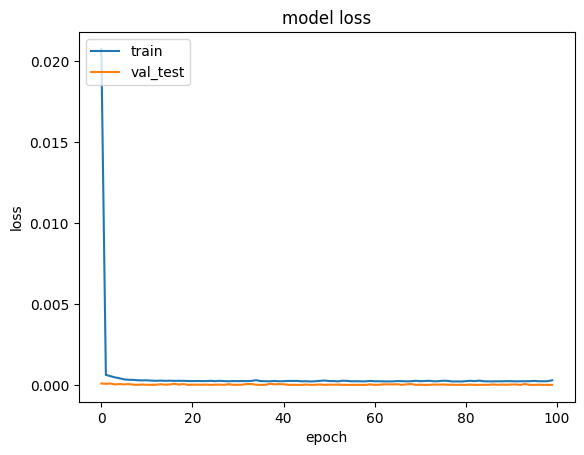

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_test'], loc='upper left')
plt.savefig('loss_ann_1day.png')

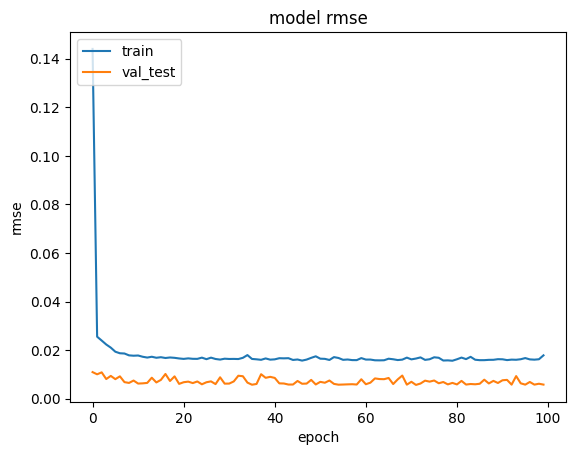

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val_test'], loc='upper left')
plt.savefig('rmse_ann_1dayoutput.png')

In [29]:
predict_y1=model.predict(testX)

6/6 [==============================] - 0s 4ms/step


In [30]:
import math
MSE = np.square(np.subtract(testY,predict_y1)).mean()      
rsme = math.sqrt(MSE)  
print("Root Mean Square Error of test data set:\n")  
print(rsme)  

Root Mean Square Error of test data set:

0.005786564125310601


In [37]:
from sklearn.metrics import r2_score

r2_score(testY, predict_y1)

0.9852568478603696

In [31]:
y_actual=testY
y_pred=predict_y1

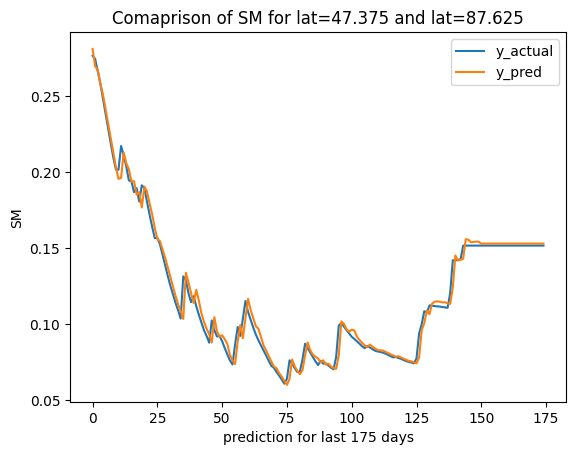

In [35]:
plt.plot(y_actual)
plt.plot(y_pred)
plt.title('Comaprison of SM for lat=47.375 and lat=87.625')
plt.ylabel('SM')
plt.xlabel('prediction for last 175 days')
plt.legend(['y_actual', 'y_pred'], loc='upper right')
plt.savefig('For_1_loc.png')

In [34]:
model.save('ann_1day.h5')